In [371]:
import pandas as pd 

In [418]:
import os
import time
import random
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
import requests
os.makedirs('Player5Games', exist_ok=True)

basestat_list = ['PTS', 'AST', 'TRB', 'STL', 'BLK', 
'PTS + AST','PTS + AST + TRB','TRB + AST']

# Webscraping 

In [419]:
player_directory = 'Wplayer_data'

#Ensure directory exists 
if not os.path.exists(player_directory):
    os.makedirs(player_directory)

def obtain_rawplayer_data(first_name, last_name):
    found_url = False
    LN_char = last_name[0].lower()
    last_part = (last_name[:5] + first_name[:2]).lower()
    unique_number = "01"
    
    # Attempt to construct the initial URL
    url = f"https://www.basketball-reference.com/wnba/players/{LN_char}/{last_part}{unique_number}w.html"
    data = requests.get(url)
    
    if data.status_code == 404:
        # Try with the next unique number
        unique_number = "02"
        url = f"https://www.basketball-reference.com/wnba/players/{LN_char}/{last_part}{unique_number}w.html"
        data = requests.get(url)  # Fetch data again with updated URL
        if data.status_code == 200:
            found_url = True
        elif data.status_code == 429:
            return "Cooldown Error"
        elif data.status_code != 200:
            return "Different Error"
    elif data.status_code == 429:
        return "Cooldown Error"
    elif data.status_code != 200:
        return "Different Error"
    else:
        found_url = True
    
    # If a valid URL was found, save the data
    if found_url:
        file_path = os.path.join(player_directory, f"{first_name} {last_name}.html")
        with open(file_path, "w+", encoding='utf-8') as f:
            f.write(data.text)
        print(f"File '{file_path}' written successfully.")


In [420]:
def isSZNInjured(df): #Outputs true if year was injured  
    columns_to_check = ["PTS", "STL", "BLK", "AST"]
    year_values = df["Year"].unique()
    injured_years = [ ] 
    
    for year in year_values:
        current_year = df[df['Year'] == year]
        if(current_year[columns_to_check] == 0).all().all(): 
                injured_years.append(year)   
    return injured_years

In [421]:
from bs4 import BeautifulSoup 

def extract5games(first_name, last_name): #obtain the df 
    file_path = os.path.join(player_directory, f"{first_name} {last_name}.html")
    csv_file_path = os.path.join(player_directory, f"{first_name}_{last_name}_last_5_games.csv")
    with open(file_path, encoding='utf-8') as f:
        page = f.read()
    soup = BeautifulSoup(page, "html.parser") 
    Last5_table = soup.find(id = "div_last5") 
    Last_5 = pd.read_html(str(Last5_table))[0]   
    #data initialization  
    unnamed_cols = [col for col in Last_5.columns if col.startswith("Unnamed")] 
    Last_5.drop(unnamed_cols, axis = 1, inplace = True)
    Last_5.fillna(0, inplace = True)
    Last_5.drop(["ORB", "Team", "Opp", "Result", "GS", "Date"], axis = 1, inplace = True) 
    Last_5['PTS + AST'] = Last_5['PTS'] + Last_5['AST']
    Last_5['PTS + AST + TRB'] = Last_5['PTS'] + Last_5['AST'] + Last_5['TRB']
    Last_5['TRB + AST'] = Last_5['TRB'] + Last_5['AST']
    Last_5['PTS + TRB'] = Last_5['PTS'] + Last_5['TRB']
    Last_5 = Last_5.apply(pd.to_numeric, errors = "coerce") 
    Last_5['Player'] = first_name + " " + last_name
    cols = ['Player'] + [col for col in Last_5 if col != 'Player']
    Last_5 = Last_5[cols]
    Last_5.to_csv(csv_file_path, index=False)
    return Last_5

# Predictor Construction

In [422]:
def extractPergameStats(first_name, last_name): 
    file_path = os.path.join(player_directory, f"{first_name} {last_name}.html")
    csv_file_path = os.path.join(player_directory, f"{first_name}_{last_name}_per_game_stats.csv")
    with open(file_path, encoding='utf-8') as f:
        page = f.read()
        
    soup = BeautifulSoup(page, "html5lib") 
    footer = soup.find("tfoot")
    footer.decompose()
    PGS_table = soup.find(id = "per_game0") 
    PGS = pd.read_html(str(PGS_table))[0]  
    
    #data initialization  
    PGS.fillna(0, inplace = True) 
    PGS.replace(to_replace = r'Did Not Play.*', value= 0, regex = True, inplace = True)
    unnamed_cols = [col for col in PGS.columns if col.startswith("Unnamed")] 
    PGS.drop(unnamed_cols, axis = 1, inplace = True)
    PGS.drop(["ORB", "Awards", "Tm"], axis = 1, inplace = True)  
    # Extract the year if needed
    PGS['Year_Only'] = PGS["Year"]
    PGS = PGS.apply(pd.to_numeric, errors = "coerce")
    
    PGS['PTS + AST'] = PGS['PTS'] + PGS['AST']
    PGS['PTS + AST + TRB'] = PGS['PTS'] + PGS['AST'] + PGS['TRB']
    PGS['TRB + AST'] = PGS['TRB'] + PGS['AST']
    PGS['PTS + TRB'] = PGS['PTS'] + PGS['TRB']
    PGS['Player'] = first_name + " " + last_name
    cols = ['Player'] + [col for col in PGS if col != 'Player']
    PGS = PGS[cols]
    injured_years = isSZNInjured(PGS) 
    if injured_years: #Check if theres injured seasons 
        PGS = PGS[~PGS["Year"].isin(injured_years)] 

    
   # Convert "Year" to datetime
    PGS["Year"] = pd.to_datetime(PGS["Year"].astype(str), format='%Y').dt.year 
    PGS.to_csv(csv_file_path, index=False)
    return PGS

In [423]:
predictors = ['GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-',
       'PTS + AST', 'PTS + AST + TRB', 'TRB + AST', 'PTS + TRB']

In [424]:
#First predictor: Rolling Average; Lower Weight 
def predict_From_Avg(target_variable, base_stat, player_df): 
    if player_df.empty: 
        raise ValueError("No Data found for player.") 

    # Ensure the target variable is numeric
    player_df[target_variable] = pd.to_numeric(player_df[target_variable], errors='coerce')

    
    player_df["lastAvg"] = player_df[target_variable].rolling(window = 5).mean() 

    if player_df["lastAvg"].dropna().empty: 
        raise ValueError("Insufficient data to calculate average") 

    last_5avg = player_df["lastAvg"].dropna().iloc[-1] 
    confidence_weight = 1.0 #Static for averages (Not enough data for LR) 
    #Make prediction
    prediction = 'Over' if last_5avg > base_stat else "Under"

    return prediction, confidence_weight


### Optimal Threshold Calculation (for consistency evaluation) 

In [425]:
#Based off of past NBA bet data, calculate the optimized threshold from the basestat to evaluate the consistency of a player
import numpy as np  
from sklearn.metrics import precision_recall_curve, f1_score 

# Load and prepare the data
BettingDF = pd.read_csv("NBA_BettingData.csv") 
BettingDF.drop("Unnamed: 0", axis=1, inplace=True)

# Map correctness values to binary labels
BettingDF["Correctness"] = BettingDF["Correctness"].map({'right': 1, 'wrong': 0})

# Extract y_true from the 'Correctness' column
y_true = BettingDF["Correctness"].values

#Rescale the deviation score to keep them in the scale between 0 and 1 
y_scores = 1 / (1 + np.abs(BettingDF["Deviation"].values))

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold, with safety against division by zero
f1_scores = np.where((precision + recall) == 0, 0, 2 * (precision * recall) / (precision + recall))

# Handle any NaN values (though np.where should avoid them)
f1_scores = np.nan_to_num(f1_scores)

# Find the threshold with the highest F1 score
if len(thresholds) > 0 and np.max(f1_scores) > 0:  
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal Threshold: {optimal_threshold}")
else:
    print("No valid optimal threshold found. Check the input data.")



Optimal Threshold: 0.1111111111111111


In [426]:
#Second predictor: Consistency
def predict_From_Consistency(target_variable, base_stat, player_df):
    if player_df.empty: 
        raise ValueError("No Data found for player.") 
    if len(player_df[target_variable]) < 3: 
        print("Insufficient data to calculate consistency.")
        return "Neither", 0

    #Calculate standard deviation of target variable 
    SDV = np.std(player_df[target_variable]) 

    #Simple linear regression on the target variable to assess consistency
    X = np.arange(len(player_df[target_variable])).reshape(-1, 1)  # Time (as index)
    y = player_df[target_variable].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    #Calculate R-squared value as a measure of consistency
    r2 = r2_score(y, y_pred)
    
    #Determine the confidence weight (you can scale or transform r2 as needed)
    confidence_weight = r2

    #Compare to the average discrepancy from the base stat based on previous betting data 
    if optimal_threshold + base_stat < base_stat + SDV:
        return "Under", confidence_weight 
    else:
        return "Over", confidence_weight 

Trend Slope: 0.6
Trend Intercept: -1208.1


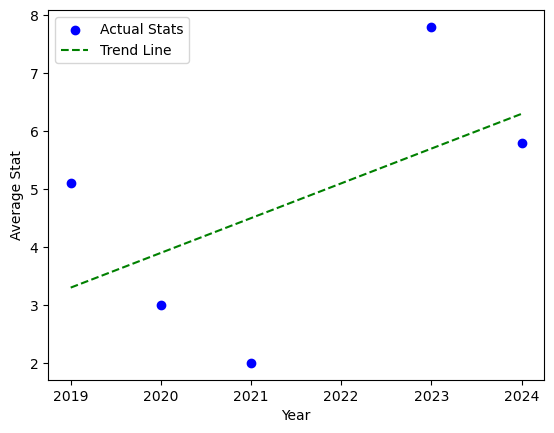

0.292738275340389


In [427]:
#Singular Test 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
years = df["Year_Only"].values.reshape(-1,1) #Reshape for SKLEARN 
stat = df["PTS"].values #Temporary varaible (change code for this in function) 

model = LinearRegression() 

model.fit(years, stat) 

#Obtain slope and interecept 
slope = model.coef_[0] 

intercept = model.intercept_ 

print(f"Trend Slope: {slope}") 
print(f"Trend Intercept: {intercept}") 

predicted_value = model.predict(years) 

#Data Visualization 
plt.scatter(years, stat, color = 'blue', label = 'Actual Stats') 
plt.plot(years, predicted_value, color = 'green', label = 'Trend Line', linestyle='dashed') 
plt.xlabel("Year") 
plt.ylabel("Average Stat") 
plt.legend() 
plt.show()

r2 = r2_score(stat, predicted_value) 

print(r2) 

In [428]:
def trendPredictor(target_variable, base_stat, player_df): 
    # Ensure there are at least two data points for linear regression
    if len(player_df) < 2:
        print("Insufficient data to calculate trend.")
        return "Neither", 0
    # Ensure the target variable is numeric
    player_df[target_variable] = pd.to_numeric(player_df[target_variable], errors='coerce')
    
    #Debug Statement 
    if "Year" not in player_df.columns:
        raise KeyError("The column 'Year' is missing from the DataFrame")
    player_df["Year"] = pd.to_datetime(player_df["Year"])

    # Drop non-numeric columns for aggregation
    numeric_cols = player_df.select_dtypes(include='number').columns
    player_df = player_df[numeric_cols]
    
    
    player_df[target_variable] = pd.to_numeric(player_df[target_variable], errors='coerce')
    base_stat = pd.to_numeric(base_stat, errors='coerce')
    
    
    #Account for injured years assuming a similar trend for time series 
    player_df["Year_Only"] = pd.to_datetime(player_df["Year_Only"]) 
    player_df.set_index("Year_Only", inplace=True)
    player_df = player_df.resample('Y').mean().reset_index()
    player_df.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

    #Convert to format Suitable for regression again 
    player_df["Year_Only"] = player_df["Year_Only"].astype('int64')
    
    years = player_df["Year_Only"].values.reshape(-1,1) 
    stats = player_df[target_variable].values 

    
    model = LinearRegression() 
    model.fit(years, stats) 

    predicted_value = model.predict(years) #Predict the target variable predicted value based on entire dataset 

    #Calculate R^2 value 

    r_squared = r2_score(stats, predicted_value) 
     
    current_year = years[-1].reshape(1,-1) 
    predicted_value = model.predict(current_year)[0] #First in the list is current year 

    c_weight = 0.0 
    
    #Compare it
    if predicted_value < base_stat: 
        prediction = "Under"
    else: 
        prediction = "Over" 
        c_weight = 0.5 #Determines the weight of this function output 

    if r_squared < 0.5: 
        print("Trend:Low Confidence Interval") 
    elif r_squared < 0.75: 
        c_weight = 1.0 
        print("Trend:Mid Confidence Interval") 
    else: 
        c_weight = 1.5 
        print("Trend:High Confidence Interval") 

    return prediction, c_weight


In [429]:
def MP_Predictor(target_variable, base_stat, player_df): 
    if len(player_df) < 2:
        print("Insufficient data to calculate trend.")
        return "Neither", 0
    x = player_df[["MP"]]
    y = player_df[target_variable] 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
    scaler = StandardScaler() 
    x_train_scaled = scaler.fit_transform(x_train) 
    x_test_scaled = scaler.transform(x_test) 
                                                        
    model = LinearRegression() 
    model.fit(x_train_scaled, y_train) #Regress over the training data 

    #Use the regression to make a prediction on the test data 
    y_pred = model.predict(x_test_scaled) 

    r2 = r2_score(y_test, y_pred) 

    if y_pred.mean() < y_test.mean(): 
        prediction = "Under" 
    else: 
        prediction = "Over" 


    if r2 < 0.5: #Determines the weight of this function output based on model effectivity 
        print("MP:Low Confidence Interval") 
        c_weight = 0.25
    elif r2 < 0.75: 
        c_weight = 0.5
        print("MP:Mid Confidence Interval") 
    else: 
        c_weight = 1.0  
        print("MP:High Confidence Interval") 

    return prediction, c_weight 


# Final Decision: Predictor Call

In [430]:
def ObtainDecision(first_name, last_name, target_variable, base_stat): 
    final_score = 0 
    #Obtain the data(frames)  
    Raw_data = obtain_rawplayer_data(first_name, last_name)
    Last_5_data = extract5games(first_name, last_name)
    PG_data = extractPergameStats(first_name, last_name)
    
    #Predictor variables 
    avg_predictor, avg_c_weight = predict_From_Avg(target_variable, base_stat, Last_5_data)
    consistency_predictor, consistency_c_weight = predict_From_Consistency(target_variable, base_stat, PG_data)
    wide_trend_predictor, w_c_weight = trendPredictor(target_variable, base_stat, PG_data)
    MP_predictor, MP_c_weight = MP_Predictor(target_variable, base_stat, PG_data)

    #Two-valued array: Indexer will have two values to check within loop 
    predictors = [(avg_predictor, avg_c_weight),
        (consistency_predictor, consistency_c_weight),
        (wide_trend_predictor, w_c_weight),
        (MP_predictor, MP_c_weight)] 
    
    
    #Analysis 
    for prediction, confidence_weight in predictors: 
        if(prediction == "Over"): 
            final_score += confidence_weight 
        elif(prediction == "Under"): 
            final_score -= confidence_weight
        else: 
            final_scMPore = final_score 

    if final_score > 0: 
        final_output = "Recommended Bet: Over" 
    else: 
        final_output = "Recommended Bet: Under" 
    
    return final_output

    



## Input Player Name, Base Stat Type and Number Here:

In [431]:
#Example 
ObtainDecision("Dearica", "Hamby", "TRB + AST", 12.5) 

File 'Wplayer_data\Dearica Hamby.html' written successfully.
Trend:High Confidence Interval
MP:Low Confidence Interval


'Recommended Bet: Under'

### Columns List

In [432]:
basestat_list

['PTS',
 'AST',
 'TRB',
 'STL',
 'BLK',
 'PTS + AST',
 'PTS + AST + TRB',
 'TRB + AST']